## 1. Writing your Tansformer

Weights are too big to be upaded on webeep, download from here:

[download weights](https://fs.polimi.it/?s=download&token=45077467-36b9-42f4-ae40-28462d7c25c7)

Standard includes, with a bit more for data visualization, dataset handling, and monitoring

We don't have datasets installed, so first we install datasets

In [ ]:
pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 12.4 MB/s eta 0:00:00


Now we can import

In [ ]:
import os
import random
import re
import string
import math
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset
from tqdm import tqdm

**Setup, Hyperparameters & Seeding**
Before starting we set all seeds to a fixed values to guarantee some level of reproducubulity of the experiment

In [ ]:
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

We check if we have a GPU available

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


And we set all required hyperparameters:


*   vocab_size: total number of unique tokens (words or subwords) in the dataset
*   sequence_length: maximum number of tokens per sentence. Longer sentences are truncated, shorter ones are padded
*   batch_size
*   embed_dim: Size of each token’s vector representation (word embedding)
*   latent_dim: hidden layer size in the feed-forward network inside each Transformer block  
*   num_heads: number of attention heads in multi-head self-attention
*   num_encoder_layers: number of stacked encoder blocks in the Transformer
*   num_decoder_layers: number of stacked decoder blocks in the Transformer
*   dropout_rate
*   num_epochs



In [ ]:
# Hyperparameters
vocab_size = 10000
sequence_length = 32         # English sequence length (adjust if needed)
batch_size = 256
embed_dim = 256              # Embedding dimension
latent_dim = 512             # Feed-forward network hidden dim
num_heads = 4
num_encoder_layers = 2
num_decoder_layers = 2
dropout_rate = 0.2
num_epochs = 20

print(f"Model parameters defined:\n"
      f"  Vocabulary size:    {vocab_size}\n"
      f"  Sequence length:    {sequence_length}\n"
      f"  Batch size:         {batch_size}\n"
      f"  Embedding dim:      {embed_dim}\n"
      f"  Latent dim:         {latent_dim}\n"
      f"  Attention heads:    {num_heads}\n"
      f"  Encoder layers:     {num_encoder_layers}\n"
      f"  Decoder layers:     {num_decoder_layers}\n")

Model parameters defined:
  Vocabulary size:    10000
  Sequence length:    32
  Batch size:         256
  Embedding dim:      256
  Latent dim:         512
  Attention heads:    4
  Encoder layers:     2
  Decoder layers:     2



Data Loading & Preprocessing

Next we load our dataset.

We want a dataset for eng-ita translation, OPUS is a dataset for english-multilingual translation. We select the eng-ita

In [ ]:
print("Loading OPUS-100 dataset (en-it)...")
opus = load_dataset("opus100", "en-it")

Loading OPUS-100 dataset (en-it)...


If you want to run on Colab you can't use the whole dataset, it would take days. So, to do some simple experiments you can test with a small subset of just 10k sentences. It will not be enough to get good translations, but you can see the model working

In [ ]:
# For demonstration, select a subset of samples.
max_train_samples = 10000
max_val_samples = 1000
max_test_samples = 1000

train_data = opus["train"].select(range(max_train_samples))
val_data = opus["validation"].select(range(max_val_samples))
test_data = opus["test"].select(range(max_test_samples))


Otherwise, if you want to train on the full dataset (DONT RUN THIS ON COLAB)

In [ ]:
train_data = opus["train"]
val_data = opus["validation"]
test_data = opus["test"]

Next we have to extract translations pairs

Each element in the dataset has this shape:



```
ex = {"translation": {"en": "Hello, how are you?", "it": "Ciao, come stai?"}}

```

So we have to extract the two sentences, and append the start and and token to the italian sentence, used to identify when the sentence start and ends.


In [ ]:
def get_pairs(dataset_split):
    pairs = []
    for ex in dataset_split:
        eng = ex["translation"]["en"]
        ita = ex["translation"]["it"]
        # Append special tokens to the Italian sentence
        ita = "[start] " + ita + " [end]"
        pairs.append((eng, ita))
    return pairs

We then generate the train/val/test splits as pairs of eng-ita sentences

In [ ]:
train_pairs = get_pairs(train_data)
val_pairs = get_pairs(val_data)
test_pairs = get_pairs(test_data)

Compute the lenght of each sentence, for the italian and english

In [ ]:
eng_lens = [len(pair[0].split()) for pair in train_pairs]
ita_lens = [len(pair[1].split()) for pair in train_pairs]

Now we visualize some statistics on the sentences. This is an helper function to pplot the sentences lenght and coompute mean values

In [ ]:
def visualize_lengths(eng_lens, ita_lens, max_length=100):
    colors = ['#2E86AB', '#A23B72']
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    fig.suptitle('Sentence Length Distributions', fontsize=14, y=1.05)
    sns.histplot(eng_lens, ax=ax1, color=colors[0], alpha=0.7, bins=120,edgecolor='black')
    ax1.axvline(np.mean(eng_lens), color=colors[1], linestyle='--',
                label=f'Mean: {np.mean(eng_lens):.1f}')
    ax1.set_title('English')
    ax1.set_xlabel('Words per Sentence')
    ax1.set_xlim(0, max_length)
    ax1.legend()
    sns.histplot(ita_lens, ax=ax2, color=colors[1], alpha=0.7, bins=240,edgecolor='black')
    ax2.axvline(np.mean(ita_lens), color=colors[0], linestyle='--',
                label=f'Mean: {np.mean(ita_lens):.1f}')
    ax2.set_title('Italian')
    ax2.set_xlabel('Words per Sentence')
    ax2.set_xlim(0, max_length)
    ax2.legend()
    plt.tight_layout()
    plt.show()
    print(f"\nDistribution summary:\n"
          f"  Total pairs:        {len(eng_lens)}\n"
          f"  Mean length (EN):   {np.mean(eng_lens):.1f}\n"
          f"  Mean length (IT):   {np.mean(ita_lens):.1f}")

Looking at the statistics many sentences are short. With english sentences slightly shorter than italian ones, as expected.

Mean value is around 10 and 11.7

But if we look at the 90 and 95 percentile in the english dataset we have 22 and 32 sentence lenght, which is in line with our sequence_lenght hyperparameter.

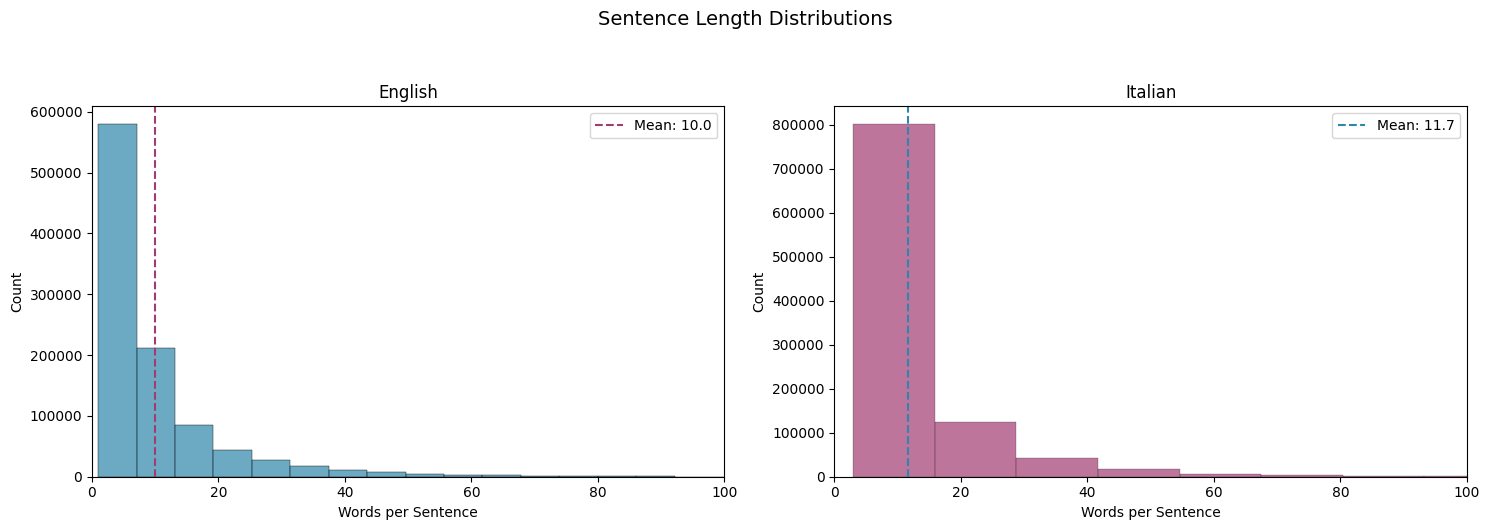


Distribution summary:
  Total pairs:        1000000
  Mean length (EN):   10.0
  Mean length (IT):   11.7

90th percentile (90% of sentences are shorter than this): 22.0
95th percentile (95% of sentences are shorter than this): 32.0


In [ ]:
visualize_lengths(eng_lens, ita_lens)
percentile_90 = np.percentile(eng_lens, 90)
percentile_95 = np.percentile(eng_lens, 95)

print(f"\n90th percentile (90% of sentences are shorter than this): {percentile_90}")
print(f"95th percentile (95% of sentences are shorter than this): {percentile_95}")


We print some examples of the training dataset

In [ ]:
print("\nRandom samples from training corpus:")
for pair in random.sample(train_pairs, 3):
    print(f"\nEN: {pair[0]}\nIT: {pair[1]}")


Random samples from training corpus:

EN: - Listen, I can't.
IT: [start] Ascolti, non posso. [end]

EN: How much?
IT: [start] - Quant'è? [end]

EN: - to finding Emmet.
IT: [start] - per trovare Emmet. [end]


**Text Standardisation & Vocabulary**

Now that we have loaded the dataset we do some preprocessing to make it simpler for our model.

The first step is to make it all lowercase and remove all punctuation, with exept for the brackets `[` and  `]`, which are used for the start and end special tokens.

In [ ]:
def custom_standardization(text):
    """Lowercase and remove punctuation (keeping [ and ] for special tokens)."""
    text = text.lower()
    punctuation = string.punctuation.replace("[", "").replace("]", "")
    return re.sub(f"[{re.escape(punctuation)}]", "", text)

Then we have to build our vocabulary. We defined a maximum size of the vocabulary using the vocab_size hyper parameter. Since we have a maximum size of words we want to take the most common ones.

we iterate thorugh all tokens, save in the counter variable the number of time each token appears in our dataset. We ordewr conter from most common to one and create the vocabolary using the two tokens required for trining, padding and unkown, and the vocabolary size -2 most common tokens. We return a set of token-index

In [ ]:
def build_vocab(texts, vocab_size):
    """Build a vocabulary from a list of texts."""
    counter = {}
    for text in texts:
        text = custom_standardization(text)
        for token in text.split():
            counter[token] = counter.get(token, 0) + 1
    sorted_tokens = sorted(counter.items(), key=lambda x: x[1], reverse=True)
    # Reserve index 0 for <pad> and index 1 for <unk>
    vocab = ["<pad>", "<unk>"]
    for token, freq in sorted_tokens[:vocab_size - len(vocab)]:
        vocab.append(token)
    token_to_idx = {token: idx for idx, token in enumerate(vocab)}
    return vocab, token_to_idx

We extact all english train paris and all italian train paris

In [ ]:
train_eng_texts = [pair[0] for pair in train_pairs]
train_ita_texts = [pair[1] for pair in train_pairs]

And we build the vocabolary for english and ita

In [ ]:
eng_vocab, eng_token_to_idx = build_vocab(train_eng_texts, vocab_size)
ita_vocab, ita_token_to_idx = build_vocab(train_ita_texts, vocab_size)
print(f"English vocabulary size: {len(eng_vocab)}")
print(f"Italian vocabulary size: {len(ita_vocab)}")

English vocabulary size: 10000
Italian vocabulary size: 10000


Then, given our vocabulary, we convert sentences into a fixed lenght numberical sequences using the mapping saved in token_to_idx

Given a text we use the previously defined function to remove punctuation and make it lowercase. Then we split into tokens and assign a number to each token, if the token exist in the vocabulary, otherwise we set 1, which represents unkown. If the lenght of the sentence is lower than the predefined sequence lenght we use padding, if it is too long we truncate it

In [ ]:
def vectorize_text(text, token_to_idx, seq_length):
    """Convert text to a list of token indices; pad or truncate to fixed length."""
    text = custom_standardization(text)
    tokens = text.split()
    indices = [token_to_idx.get(token, 1) for token in tokens]  # 1 is <unk>
    if len(indices) < seq_length:
        indices = indices + [0] * (seq_length - len(indices))
    else:
        indices = indices[:seq_length]
    return indices


For the italian sentences, which are the ouput of the model, we set a fixed size

In [ ]:
# For Italian we use a fixed length = sequence_length + 1
ita_seq_len = sequence_length + 1

We can test our function and see how it behave

In [ ]:
vectorize_text("hello world ", eng_token_to_idx, seq_length=5)

[528, 190, 0, 0, 0]

In [ ]:
vectorize_text("hello world, this is a message! ", eng_token_to_idx, seq_length=5)

[528, 190, 15, 10, 7]

**PyTorch Dataset & DataLoader**

Next we have to create the dataloader, for the moment we only wrote data processing functions

The function, given a pair, vectorize the english and italian sentences and convert them into a pytorch tensor.

Next we return the english tensor, and the two italian tensors used for training, the decoder input, which is the italian tensor minus the last element, and the target, which is the italian tensor minus the first element. This is because at trainig time we don't predict the whole sentence, but only the next token. So we have an input in italian, and an output in italian, which is shifted by one.

In [ ]:
class TranslationDataset(Dataset):
    def __init__(self, pairs, eng_token_to_idx, ita_token_to_idx, eng_seq_len, ita_seq_len):
        self.pairs = pairs
        self.eng_token_to_idx = eng_token_to_idx
        self.ita_token_to_idx = ita_token_to_idx
        self.eng_seq_len = eng_seq_len
        self.ita_seq_len = ita_seq_len
    def __len__(self):
        return len(self.pairs)
    def __getitem__(self, idx):
        eng, ita = self.pairs[idx]
        eng_vec = vectorize_text(eng, self.eng_token_to_idx, self.eng_seq_len)
        ita_vec = vectorize_text(ita, self.ita_token_to_idx, self.ita_seq_len)
        eng_tensor = torch.tensor(eng_vec, dtype=torch.long)
        ita_tensor = torch.tensor(ita_vec, dtype=torch.long)
        # For the decoder: input is all but the last token, target is all but the first token
        decoder_input = ita_tensor[:-1]
        target = ita_tensor[1:]
        return eng_tensor, decoder_input, target

Next we create the dataset and dataloaders

In [ ]:
train_dataset = TranslationDataset(train_pairs, eng_token_to_idx, ita_token_to_idx, sequence_length, ita_seq_len)
val_dataset = TranslationDataset(val_pairs, eng_token_to_idx, ita_token_to_idx, sequence_length, ita_seq_len)
test_dataset = TranslationDataset(test_pairs, eng_token_to_idx, ita_token_to_idx, sequence_length, ita_seq_len)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

sample_eng, sample_dec_in, sample_target = next(iter(train_loader))
print(f"Sample batch shapes:\n"
      f"  Encoder inputs:  {sample_eng.shape}\n"
      f"  Decoder inputs:  {sample_dec_in.shape}\n"
      f"  Target outputs:  {sample_target.shape}")

Sample batch shapes:
  Encoder inputs:  torch.Size([256, 32])
  Decoder inputs:  torch.Size([256, 32])
  Target outputs:  torch.Size([256, 32])


**Model Definition**

We now have to define how data are encoded inside our network. Two core components, word embedding and positional encoding.

In the forward pass, given a batch with batch size sequences of n tokens the word embedding is computed for each one of them.

Then we transpose it to have the proper shape and compute the positional encoding using the defined function.

get_positional_encoding compute the values of the positional encoding which are summed to the word embedding to provide position information of the token to the model.



In [ ]:
class PositionalEmbedding(nn.Module):
    def __init__(self, vocab_size, embed_dim, max_len):
        super().__init__()
        self.token_embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.embed_dim = embed_dim
        self.max_len = max_len
        self.register_buffer("pos_encoding", self.get_positional_encoding(max_len, embed_dim))
    def get_positional_encoding(self, max_len, d_model):
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2, dtype=torch.float) * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(1)  # shape: (max_len, 1, d_model)
        return pe
    def forward(self, x):
        # x: (batch, seq_len)
        x = self.token_embedding(x)  # (batch, seq_len, embed_dim)
        x = x.transpose(0, 1)         # (seq_len, batch, embed_dim)
        seq_len = x.size(0)
        x = x + self.pos_encoding[:seq_len, :]
        return x

To get a better idea of what the positional encoding is doing, here is the raw data of the positional encoding that are summed to the word embedding, for a sequence of lenght 100 (rows), and visualizing the first 40 values of the embedding (out of 512)

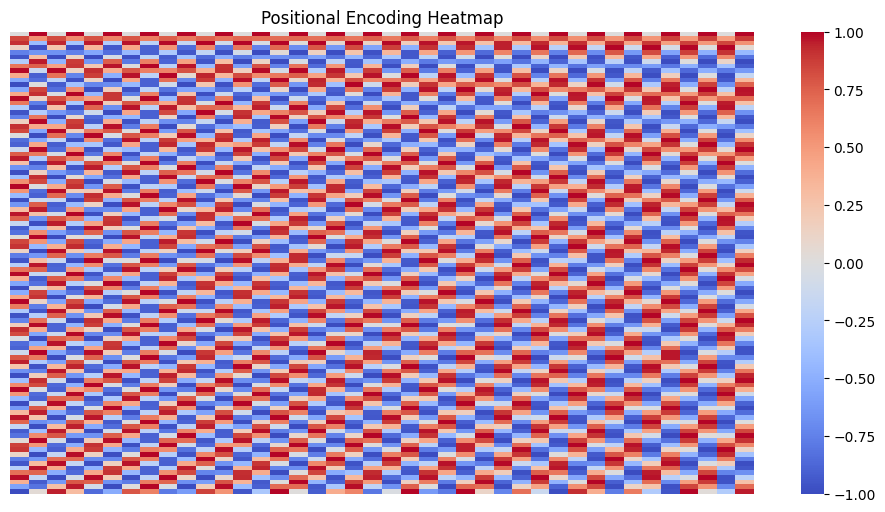

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def get_positional_encoding( max_len, d_model):
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2, dtype=torch.float) * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        return pe

pe = get_positional_encoding(100, 512).numpy()  # Generate encoding for 100 positions
plt.figure(figsize=(12, 6))
sns.heatmap(pe[:, :40], cmap="coolwarm", xticklabels=False, yticklabels=False)
plt.title("Positional Encoding Heatmap")
plt.show()


We now implement the first block of out transformer, the encoder branch. In particular the four blocks:


*   Multi-Head Self-Attention (self_attn)
*   Add & Normalize
*   Feed-Forward Network (ff)
*   Add & Normalize



In [ ]:
class TransformerEncoderBlock(nn.Module):
    def __init__(self, embed_dim, ff_dim, num_heads, dropout_rate=0.1):
        super().__init__()
        self.self_attn = nn.MultiheadAttention(embed_dim, num_heads, dropout=dropout_rate)
        self.norm1 = nn.LayerNorm(embed_dim)
        self.norm2 = nn.LayerNorm(embed_dim)
        self.dropout1 = nn.Dropout(dropout_rate)
        self.dropout2 = nn.Dropout(dropout_rate)
        self.ff = nn.Sequential(
            nn.Linear(embed_dim, ff_dim),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(ff_dim, embed_dim)
        )
    def forward(self, x, src_mask=None, src_key_padding_mask=None):
        attn_output, _ = self.self_attn(x, x, x, attn_mask=src_mask, key_padding_mask=src_key_padding_mask)
        x = x + self.dropout1(attn_output)
        x = self.norm1(x)
        ff_output = self.ff(x)
        x = x + self.dropout2(ff_output)
        x = self.norm2(x)
        return x

And here we implement the decoder branch with:


*   Masked Self-Attention
*   Cross-Attention with Encoder Outputs
*   Feed-Forward Network
*   Residual Connections & Layer Normalization




In [ ]:
class TransformerDecoderBlock(nn.Module):
    def __init__(self, embed_dim, ff_dim, num_heads, dropout_rate=0.1):
        super().__init__()
        self.self_attn = nn.MultiheadAttention(embed_dim, num_heads, dropout=dropout_rate)
        self.cross_attn = nn.MultiheadAttention(embed_dim, num_heads, dropout=dropout_rate)
        self.norm1 = nn.LayerNorm(embed_dim)
        self.norm2 = nn.LayerNorm(embed_dim)
        self.norm3 = nn.LayerNorm(embed_dim)
        self.dropout1 = nn.Dropout(dropout_rate)
        self.dropout2 = nn.Dropout(dropout_rate)
        self.dropout3 = nn.Dropout(dropout_rate)
        self.ff = nn.Sequential(
            nn.Linear(embed_dim, ff_dim),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(ff_dim, embed_dim),
            nn.Dropout(dropout_rate)
        )
    def forward(self, x, memory, tgt_mask=None, tgt_key_padding_mask=None, memory_key_padding_mask=None):
        # Masked self-attention
        self_attn_output, _ = self.self_attn(x, x, x, attn_mask=tgt_mask, key_padding_mask=tgt_key_padding_mask)
        x = x + self.dropout1(self_attn_output)
        x = self.norm1(x)
        # Cross-attention with encoder outputs
        cross_attn_output, _ = self.cross_attn(x, memory, memory, key_padding_mask=memory_key_padding_mask)
        x = x + self.dropout2(cross_attn_output)
        x = self.norm2(x)
        # Feed-forward network
        ff_output = self.ff(x)
        x = x + self.dropout3(ff_output)
        x = self.norm3(x)
        return x

Finally we combine everything togather to get the complete model

We first compute the positional embeddings for the source and the target

We define the encoder and decoder layers with size regulated by the hyperparameters set at the beginnning

We map wiht a linear layer the decoder output to a probability distribution with size equal to our vocabolary

In the forward pass, we take a sequence as input and we compute positional embedding

Then each encoder layer process iteratively the embedding and we get memory, which is passed to the decoder

We process also the target and apply the mask to prevent looking at future tokens

And we run through the decoder

Finally we pass the input to the linear layer to produce the output

In [ ]:
class TransformerNMT(nn.Module):
    def __init__(self, vocab_size, seq_len, embed_dim, ff_dim, num_heads, num_encoder_layers, num_decoder_layers, dropout_rate=0.1):
        super().__init__()
        self.src_embedding = PositionalEmbedding(vocab_size, embed_dim, seq_len)
        # Decoder embedding uses maximum length = seq_len + 1
        self.tgt_embedding = PositionalEmbedding(vocab_size, embed_dim, seq_len + 1)
        self.encoder_layers = nn.ModuleList([
            TransformerEncoderBlock(embed_dim, ff_dim, num_heads, dropout_rate)
            for _ in range(num_encoder_layers)
        ])
        self.decoder_layers = nn.ModuleList([
            TransformerDecoderBlock(embed_dim, ff_dim, num_heads, dropout_rate)
            for _ in range(num_decoder_layers)
        ])
        self.fc_out = nn.Linear(embed_dim, vocab_size)
    def generate_square_subsequent_mask(self, sz):
        mask = torch.triu(torch.full((sz, sz), float('-inf')), diagonal=1)
        return mask
    def forward(self, src, tgt):
        # src: (batch, seq_len), tgt: (batch, tgt_seq_len)
        src_emb = self.src_embedding(src)  # (seq_len, batch, embed_dim)
        memory = src_emb
        for layer in self.encoder_layers:
            memory = layer(memory)
        tgt_emb = self.tgt_embedding(tgt)  # (tgt_seq_len, batch, embed_dim)
        tgt_seq_len = tgt_emb.size(0)
        tgt_mask = self.generate_square_subsequent_mask(tgt_seq_len).to(tgt.device)
        out = tgt_emb
        for layer in self.decoder_layers:
            out = layer(out, memory, tgt_mask=tgt_mask)
        output = self.fc_out(out)  # (tgt_seq_len, batch, vocab_size)
        output = output.transpose(0, 1)  # (batch, tgt_seq_len, vocab_size)
        return output

Now that all the architecture is defined we can start the training process.

We create our model, and load a pretrained model if available

In [ ]:
# Instantiate the model and move to device
model = TransformerNMT(vocab_size, sequence_length, embed_dim, latent_dim, num_heads, num_encoder_layers, num_decoder_layers, dropout_rate)
try:
    model.load_state_dict(torch.load("best_transformer_nmt.pth", map_location=device))
except:
    print ("no model to load")
model = model.to(device)
print(model)

if torch.cuda.device_count() > 1:
    print("Using", torch.cuda.device_count(), "GPUs!")
    model = torch.nn.DataParallel(model)

no model to load
TransformerNMT(
  (src_embedding): PositionalEmbedding(
    (token_embedding): Embedding(10000, 256, padding_idx=0)
  )
  (tgt_embedding): PositionalEmbedding(
    (token_embedding): Embedding(10000, 256, padding_idx=0)
  )
  (encoder_layers): ModuleList(
    (0-1): 2 x TransformerEncoderBlock(
      (self_attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
      )
      (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (dropout1): Dropout(p=0.2, inplace=False)
      (dropout2): Dropout(p=0.2, inplace=False)
      (ff): Sequential(
        (0): Linear(in_features=256, out_features=512, bias=True)
        (1): ReLU()
        (2): Dropout(p=0.2, inplace=False)
        (3): Linear(in_features=512, out_features=256, bias=True)
      )
    )
  )
  (decoder_layers): ModuleList(
    (0-1): 2 x TransformerDecoderBlock(

<ipython-input-132-58b1a091d504>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_transformer_nmt.pth", map_location=device))


We set the loss and the optimizer

In [ ]:
criterion = nn.CrossEntropyLoss(ignore_index=0)
optimizer = optim.Adam(model.parameters(), lr=0.0001)

And we define our training function. We pass to the model the source, the input to the decoder and the target. We predict, compute the loss and perform back propagation

In [ ]:
def train_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    for batch in tqdm(dataloader, desc="Training", leave=False):
        #for batch in dataloader:
        src, tgt_input, tgt_target = batch
        src = src.to(device)
        tgt_input = tgt_input.to(device)
        tgt_target = tgt_target.to(device)
        optimizer.zero_grad()
        # Forward pass (teacher forcing)
        output = model(src, tgt_input)
        # output: (batch, tgt_seq_len, vocab_size)
        loss = criterion(output.reshape(-1, vocab_size), tgt_target.reshape(-1))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(dataloader)

We also define the evaluate function

In [ ]:
def evaluate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for batch in dataloader:
            src, tgt_input, tgt_target = batch
            src = src.to(device)
            tgt_input = tgt_input.to(device)
            tgt_target = tgt_target.to(device)
            output = model(src, tgt_input)
            loss = criterion(output.reshape(-1, vocab_size), tgt_target.reshape(-1))
            total_loss += loss.item()
    return total_loss / len(dataloader)

We add a scheduler to stop training if overfitting

In [ ]:
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

best_val_loss = float('inf')
patience_counter = 0
max_patience = 15

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


And we start the training phase

In [ ]:
print("Starting training...")
for epoch in range(1, num_epochs + 1):
    train_loss = train_epoch(model, train_loader, optimizer, criterion, device)
    val_loss = evaluate(model, val_loader, criterion, device)
    scheduler.step(val_loss)
    print(f"Epoch {epoch}: Train Loss = {train_loss:.4f}, Val Loss = {val_loss:.4f}")

    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        # Optionally, save the model checkpoint here
        torch.save(model.state_dict(), "best_transformer_nmt.pth")
    else:
        patience_counter += 1
        if patience_counter >= max_patience:
            print("Early stopping triggered")
            break

# Save the trained model
torch.save(model.state_dict(), "transformer_nmt_pytorch.pth")
print("Model saved as transformer_nmt_pytorch.pth")

Starting training...


Epoch 1: Train Loss = 6.2348, Val Loss = 5.6970


Epoch 2: Train Loss = 6.1747, Val Loss = 5.6609


Epoch 3: Train Loss = 6.1033, Val Loss = 5.6064


Epoch 4: Train Loss = 6.0313, Val Loss = 5.5539


Epoch 5: Train Loss = 5.9717, Val Loss = 5.5098


Epoch 6: Train Loss = 5.8988, Val Loss = 5.4514


Epoch 7: Train Loss = 5.8264, Val Loss = 5.4174


Epoch 8: Train Loss = 5.7645, Val Loss = 5.3535


Epoch 9: Train Loss = 5.6905, Val Loss = 5.3175


Epoch 10: Train Loss = 5.6278, Val Loss = 5.2745


Epoch 11: Train Loss = 5.5528, Val Loss = 5.2321


Epoch 12: Train Loss = 5.4812, Val Loss = 5.2202


Epoch 13: Train Loss = 5.4172, Val Loss = 5.1575


Epoch 14: Train Loss = 5.3399, Val Loss = 5.1251


Epoch 15: Train Loss = 5.2970, Val Loss = 5.0976


Epoch 16: Train Loss = 5.2174, Val Loss = 5.0804


Epoch 17: Train Loss = 5.1644, Val Loss = 5.0418


Epoch 18: Train Loss = 5.1016, Val Loss = 5.0272


Epoch 19: Train Loss = 5.0378, Val Loss = 4.9885


Epoch 20: Train Loss = 5.0087, Val Loss = 4.9588
Model saved as transformer_nmt_pytorch.pth


Once we got a decent model is time to test it!

We write a function that takes one token at the time and guardually build the translation, until it finds the end token

In [ ]:
def translate_text(model, input_sentence, eng_token_to_idx, ita_idx_to_token, sequence_length, max_len=20, device="cuda"):

    model.eval()  # Set model to evaluation mode

    # Convert input sentence to token indices
    src_indices = vectorize_text(input_sentence, eng_token_to_idx, sequence_length)
    src_tensor = torch.tensor(src_indices, dtype=torch.long).unsqueeze(0).to(device)  # Shape: (1, seq_len)

    # Initialize decoder with `[start]` token
    start_token = ita_token_to_idx.get("[start]", 1)
    decoder_input = torch.tensor([[start_token]], dtype=torch.long).to(device)  # Shape: (1, 1)

    decoded_tokens = []
    with torch.no_grad():
        for _ in range(max_len):
            output = model(src_tensor, decoder_input)  # (1, current_len, vocab_size)
            next_token_logits = output[:, -1, :]  # Extract last token probabilities
            next_token = next_token_logits.argmax(dim=-1).item()  # Select most probable token

            # Append next token and update decoder input
            decoded_tokens.append(next_token)
            decoder_input = torch.cat([decoder_input, torch.tensor([[next_token]], device=device)], dim=1)

            # Stop if `[end]` token is generated
            if ita_idx_to_token.get(next_token, "") == "[end]":
                break

    # Convert token indices to words
    translated_sentence = " ".join([ita_idx_to_token.get(idx, "<unk>") for idx in decoded_tokens])

    return translated_sentence


We now test it on really simple sentences.

We had a small dictionary, maaning many words are unkown to the model

In [ ]:
# Ensure the model is loaded and tokenizer mappings exist
ita_idx_to_token = {idx: token for token, idx in ita_token_to_idx.items()}

# Example sentence to translate
english_sentence = "How are you?"

# Translate the sentence
translation = translate_text(model, english_sentence, eng_token_to_idx, ita_idx_to_token, sequence_length, max_len=20, device=device)

print(f"\nEnglish: {english_sentence}\nItalian: {translation}")



English: How are you?
Italian: aumentata campi ritardo langolo quanto doloroso affermato formulato rosso legittimo doloroso jen xii dichiarazioni solo aumentata cambiano convinto eccoti lacrime


Indeed, if we look at the dictionary we can notiece how many common use nouns are still missing

In [ ]:
print("First 100 words in the English vocabulary:\n")
for i, (token, idx) in enumerate(list(eng_token_to_idx.items())[:100]):
    print(f"{idx:5} → {token}")

First 100 words in the English vocabulary:

    0 → <pad>
    1 → <unk>
    2 → the
    3 → of
    4 → to
    5 → and
    6 → you
    7 → a
    8 → in
    9 → i
   10 → is
   11 → that
   12 → it
   13 → for
   14 → on
   15 → this
   16 → be
   17 → with
   18 → we
   19 → are
   20 → not
   21 → have
   22 → me
   23 → was
   24 → what
   25 → no
   26 → as
   27 → its
   28 → your
   29 → my
   30 → all
   31 → by
   32 → do
   33 → at
   34 → but
   35 → he
   36 → im
   37 → from
   38 → or
   39 → so
   40 → know
   41 → can
   42 → just
   43 → dont
   44 → if
   45 → will
   46 → an
   47 → like
   48 → they
   49 → out
   50 → one
   51 → were
   52 → there
   53 → about
   54 → which
   55 → here
   56 → up
   57 → get
   58 → well
   59 → has
   60 → right
   61 → him
   62 → youre
   63 → go
   64 → now
   65 → her
   66 → his
   67 → been
   68 → who
   69 → how
   70 → our
   71 → she
   72 → when
   73 → time
   74 → would
   75 → want
   76 → got
   77 → more
   78 → th

Now lets load a big model

In [ ]:
vocab_size = 32000
sequence_length = 32         # English sequence length (you can adjust if needed)
batch_size = 256
embed_dim = 1024              # Embedding dimension
latent_dim = 2048             # Feed-forward network hidden dim
num_heads = 8
num_encoder_layers = 6
num_decoder_layers = 6
dropout_rate = 0.2


We also have to regenerate the dictionary

In [ ]:
train_data = opus["train"]
val_data = opus["validation"]
test_data = opus["test"]
train_pairs = get_pairs(train_data)
val_pairs = get_pairs(val_data)
test_pairs = get_pairs(test_data)

train_eng_texts = [pair[0] for pair in train_pairs]
train_ita_texts = [pair[1] for pair in train_pairs]

eng_vocab, eng_token_to_idx = build_vocab(train_eng_texts, vocab_size)
ita_vocab, ita_token_to_idx = build_vocab(train_ita_texts, vocab_size)
print(f"English vocabulary size: {len(eng_vocab)}")
print(f"Italian vocabulary size: {len(ita_vocab)}")

English vocabulary size: 32000
Italian vocabulary size: 32000


Redefine the model with the new parameters

In [ ]:
model = TransformerNMT(vocab_size, sequence_length, embed_dim, latent_dim, num_heads, num_encoder_layers, num_decoder_layers, dropout_rate)

Load the model weights

In [ ]:
model.load_state_dict(torch.load("/content/big_transformer.pth", map_location=device))
model.to("cuda")

<ipython-input-143-2e2267b2d563>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/content/big_transformer.pth", map_location=device))


TransformerNMT(
  (src_embedding): PositionalEmbedding(
    (token_embedding): Embedding(32000, 1024, padding_idx=0)
  )
  (tgt_embedding): PositionalEmbedding(
    (token_embedding): Embedding(32000, 1024, padding_idx=0)
  )
  (encoder_layers): ModuleList(
    (0-5): 6 x TransformerEncoderBlock(
      (self_attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=1024, out_features=1024, bias=True)
      )
      (norm1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (dropout1): Dropout(p=0.2, inplace=False)
      (dropout2): Dropout(p=0.2, inplace=False)
      (ff): Sequential(
        (0): Linear(in_features=1024, out_features=2048, bias=True)
        (1): ReLU()
        (2): Dropout(p=0.2, inplace=False)
        (3): Linear(in_features=2048, out_features=1024, bias=True)
      )
    )
  )
  (decoder_layers): ModuleList(
    (0-5): 6 x TransformerDecoderBlock(
      

Now we try again on some sequnce

In [ ]:
# Ensure the model is loaded and tokenizer mappings exist
ita_idx_to_token = {idx: token for token, idx in ita_token_to_idx.items()}


# Example sentence to translate
english_sentence = "The pen is on the table?"

# Translate the sentence
translation = translate_text(model, english_sentence, eng_token_to_idx, ita_idx_to_token, sequence_length, max_len=20, device=device)

print(f"\nEnglish: {english_sentence}\nItalian: {translation}")


English: The pen is on the table?
Italian: la penna è sul tavolo [end]


You don't have to always write this from scratch. Nowaday everyone is using transformers, so many libraries implement them. The model can be written using the transformer library and the Transformer function, which fully carachterize the architecture we previously wrote

In [ ]:
from torch.nn import Transformer
class Seq2SeqTransformer(nn.Module):
    def __init__(self, vocab_size, embed_size, num_heads, ff_size, num_layers):
        super().__init__()
        self.transformer = Transformer(d_model=embed_size, nhead=num_heads, num_encoder_layers=num_layers,
                                       num_decoder_layers=num_layers, dim_feedforward=ff_size)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.fc_out = nn.Linear(embed_size, vocab_size)

    def forward(self, src, tgt):
        src = self.embedding(src)
        tgt = self.embedding(tgt)
        output = self.transformer(src, tgt)
        return self.fc_out(output)

# Initialize Model
model = Seq2SeqTransformer(vocab_size=len(vocab_en), embed_size=512, num_heads=8, ff_size=1024, num_layers=6)

## BERT ##


We developed a sequence to sequence architecture, which took as input our english text and, one token after the other, returned the italian translation.

Now we analyze a different text-based transformer architecture, BERT.
The core feature of bert is the bidirectional encoding, the model is not focusing only on the next word, but looks in both directions.
For this reason the training process of bert differs from the one of our translation model, and lavarages two core ideas:


*   masked words prediction
*   next sentence prediction



We start with some standard include. Now that we know how the transformer architecture work we will lavarage some existing libraries

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader,random_split
from torch.nn import TransformerEncoder, TransformerEncoderLayer
import numpy as np
import random
from datasets import load_dataset
from transformers import BertTokenizer
from tqdm import tqdm

In [ ]:
# Device Configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Now we have to load a good dataset to train our model. The original BERT is trained on a 16GB dataset, which takes long even on a server. We use a medium sized one, which might allow  the model to learn something, but maybe not everything.

In [ ]:
dataset = load_dataset("wikitext", "wikitext-103-v1", split="train", cache_dir="./wikitext_data")  #
texts = dataset["text"]  #

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/722k [00:00<?, ?B/s]

train-00000-of-00002.parquet:   0%|          | 0.00/156M [00:00<?, ?B/s]

train-00001-of-00002.parquet:   0%|          | 0.00/156M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/655k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/4358 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/1801350 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3760 [00:00<?, ? examples/s]

We have to preprocess the dataset to split the paragraph into sentences, and we take only the 10% to do some fast training

In [ ]:
sentences = [sent.strip() + "." for paragraph in texts for sent in paragraph.split(".") if len(sent.strip()) > 5]
subset_size = int(0.1 * len(sentences))  # 10% of dataset
sentences = sentences[:subset_size]

Now that we have a dataset we have to convert it into token.

We will not write the whole processing pipeline like in the previous example, but we lavarage an already available function which performs all the processing.

In [ ]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

The tokenizer has similar step to the one we saw previously.

Lowercase all characters

Split the text into tokens. Not always at words level, but depending on the word it can use subwords

In [ ]:
tokenizer.tokenize("I love transformers!")

['i', 'love', 'transformers', '!']

In [ ]:
tokenizer.tokenize("tokenization")

['token', '##ization']

If we look at the direct output of the tokenizer we get three fields

*   input ids: are the numeric value of the token. Some are standard token like 101 for the start, 102 to separate sentences, 0 is padding
*   token type ids: used to tell which token are from the first and which tokens are from the second sentence
*   attention mask: used to identify which tokens are words and attention should be applied, and which ones are simply padding



In [ ]:
tokenizer("I love deep learning.", "Transformers are amazing.", max_length=15, padding="max_length")

{'input_ids': [101, 1045, 2293, 2784, 4083, 1012, 102, 19081, 2024, 6429, 1012, 102, 0, 0, 0], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0]}

Now we have to generate the data for our task, first next sentence prediction.

Our dataset already provide long text sequences splitted into shorter sentences. This function then iterate though a text and starging from a sentence randomly choose the next one, or another random one, returning the two sentences and the ground truth label

In [ ]:
def create_sentence_pairs(texts, max_samples=None):
    """Creates sentence pairs for Next Sentence Prediction (NSP)."""
    sentence_pairs = []
    for i in range(len(texts) - 1):
        if random.random() < 0.5:
            sent1, sent2, is_next = texts[i], texts[i + 1], 1
        else:
            sent1, sent2, is_next = texts[i], random.choice(texts), 0
        sentence_pairs.append((sent1, sent2, is_next))
        if max_samples and len(sentence_pairs) >= max_samples:
            break
    return sentence_pairs

sentence_pairs = create_sentence_pairs(texts)

To see how it works we test it on a small texts set

In [ ]:
texts = [
    "This is the first sentence.",
    "Now we have the second one.",
    "After we add the third.",
    "And then the fourth.",
    "Finally we conclude with the fifth."
]

# Generate sentence pairs
sentence_pairs = create_sentence_pairs(texts, max_samples=4)
print("\n **Generated Sentence Pairs for NSP:**\n")
for sent1, sent2, is_next in sentence_pairs:
    print(f" Sentence 1: {sent1}")
    print(f" Sentence 2: {sent2}")
    print(f"Is Next Sentence? {'YES' if is_next else 'NO'}")
    print("-" * 50)


 **Generated Sentence Pairs for NSP:**

 Sentence 1: This is the first sentence.
 Sentence 2: Now we have the second one.
Is Next Sentence? YES
--------------------------------------------------
 Sentence 1: Now we have the second one.
 Sentence 2: And then the fourth.
Is Next Sentence? NO
--------------------------------------------------
 Sentence 1: After we add the third.
 Sentence 2: And then the fourth.
Is Next Sentence? YES
--------------------------------------------------
 Sentence 1: And then the fourth.
 Sentence 2: This is the first sentence.
Is Next Sentence? NO
--------------------------------------------------


Now we have to generate our dataset to train the model. Given the downloaded dataset the core steps are:



*   tokenization
*   masked language modelling
*   next sentence prediction

the mask tokens function takes as input a list of token ids and randomly mask them, with probability 0.15. It masks only token which belongs to words, not tokens beloning to start, end or padding. It returns both the masked one and the original one

The get item function lavarages this and the previously defined sentence pairs functions. It retrieve a sentence pair, which can be consecutive sentences or not, apply the masking, and returns the two sentences masked , the two original sentences and the label for next sentence prediction



In [ ]:
class BertDataset(Dataset):
    def __init__(self, sentences, tokenizer, mask_prob=0.15, max_length=128):
        self.sentences = sentences
        self.tokenizer = tokenizer
        self.mask_prob = mask_prob
        self.max_length = max_length

    def encode(self, sent1, sent2):
        """Tokenizes two sentences together (ensures [SEP] is in the middle)."""
        enc = self.tokenizer(sent1, sent2, truncation=True, padding="max_length",
                             max_length=self.max_length, return_tensors="pt")
        return enc["input_ids"].squeeze(0)

    def mask_tokens(self, input_ids):
        labels = input_ids.clone()
        for i in range(len(input_ids)):
            if random.random() < self.mask_prob and input_ids[i] not in [tokenizer.pad_token_id, tokenizer.cls_token_id, tokenizer.sep_token_id]:
                input_ids[i] = tokenizer.mask_token_id
        return input_ids, labels

    def __len__(self):
        return len(self.sentences) -1

    def __getitem__(self, idx):

        sent1 = self.sentences[idx]

        # 50% of the time, use the real next sentence
        if random.random() < 0.5 and idx < len(self.sentences) - 1:
            sent2 = self.sentences[idx + 1]
            is_next = 1
        else:
            sent2 = random.choice(self.sentences)
            is_next = 0

        # Tokenize and mask tokens for MLM
        input_ids = self.encode(sent1, sent2)
        masked_input, masked_labels = self.mask_tokens(input_ids.clone())

        return masked_input, masked_labels, torch.tensor(is_next)

We can use our previous list of sentences to see how data are generated from the dataset function.

In [ ]:
# Sample text (list of independent sentences)
example_sentences = [
    "This is the first sentence.",
    "Now we have the second one.",
    "After we add the third.",
    "And then the fourth.",
    "Finally we conclude with the fifth."
]

# Load BERT tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Create dataset
example_dataset = BertDataset(example_sentences, tokenizer)

# Pick a sample from the dataset (e.g., index 0)
masked_input, masked_labels, is_next = example_dataset[0]

# Decode input tokens
decoded_masked = tokenizer.convert_ids_to_tokens(masked_input.tolist())
decoded_labels = tokenizer.convert_ids_to_tokens(masked_labels.tolist())

# Print results
print("\n Generated Sample for BERT Training:\n")
print(f" Sentence 1 + Sentence 2 (with Masking): {' '.join(decoded_masked)}")
print(f" Original Sentences (for MLM): {' '.join(decoded_labels)}")
print(f" Is Next Sentence? {'YES' if is_next.item() == 1 else 'NO'}")



 Generated Sample for BERT Training:

 Sentence 1 + Sentence 2 (with Masking): [CLS] this [MASK] the [MASK] sentence . [SEP] and then the fourth . [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
 Original Sentences (for MLM): [CLS] this is the first sentence . [SEP] and then the fourth . [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [P

Now we create the real dataset, split it in train and valiation, and create the dataloaders

In [ ]:
dataset = BertDataset(sentences, tokenizer)

train_size = int(0.9 * len(dataset))  # 90% train, 10% validation
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

Finally we need to define the architecture

This time we lavarage the available pytorch classes, therefore we don't have to manually implement the transformer architecture

Similarly to our previous example the first step convert the words into an embedding space

Next we add to our model num_layers transformer encoder layers

Finally we set the two heads of the model, the one predicting the masking and the one predicting if the two sentence are one next to the other

In [ ]:
class BERT(nn.Module):
    def __init__(self, vocab_size, hidden_size, num_heads, num_layers, feedforward_dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_size, padding_idx=tokenizer.pad_token_id)


        encoder_layer = TransformerEncoderLayer(d_model=hidden_size, nhead=num_heads, dim_feedforward=feedforward_dim)
        self.encoders = TransformerEncoder(encoder_layer, num_layers=num_layers)

        self.mlm_head = nn.Linear(hidden_size, vocab_size)
        self.nsp_head = nn.Linear(hidden_size, 2)

    def forward(self, input_ids):
        x = self.embedding(input_ids)
        x = self.encoders(x)
        mlm_logits = self.mlm_head(x)
        nsp_logits = self.nsp_head(x[:, 0, :])
        return mlm_logits, nsp_logits

Now that we have designed the model, created the dataset, we can start the training phase

We create a BERT network with similar parameters and number of layers to the one of the originalpaper

We use standard optimized and loss functions

In [ ]:
model = BERT(vocab_size=tokenizer.vocab_size, hidden_size=768, num_heads=12, num_layers=12, feedforward_dim=3072).to(device)
optimizer = optim.Adam(model.parameters(), lr=3e-4)
criterion = nn.CrossEntropyLoss()

best_loss = float("inf")
patience, patience_counter = 3, 0

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Now we can start the training of the model

we iterate thrugh batches of the data loader, we run the model and predict the masking and next sentence class. We compute a loss on these two and sum them to get the final loss.

In [ ]:
for epoch in range(1):
    model.train()
    total_loss = 0
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}", dynamic_ncols=True, leave=True)

    for input_ids, labels, is_next in progress_bar:
        input_ids, labels, is_next = input_ids.to(device), labels.to(device), is_next.to(device)
        optimizer.zero_grad()
        mlm_logits, nsp_logits = model(input_ids)
        mlm_loss = criterion(mlm_logits.view(-1, tokenizer.vocab_size), labels.view(-1))
        nsp_loss = criterion(nsp_logits, is_next)
        loss = mlm_loss + nsp_loss
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        progress_bar.set_postfix(loss=f"{loss.item():.3f}")

    val_loss = sum(criterion(model(input_ids.to(device))[0].view(-1, tokenizer.vocab_size), labels.to(device).view(-1)).item() for input_ids, labels, _ in val_loader) / len(val_loader)
    print(f"Epoch {epoch+1} - Train Loss: {total_loss/len(train_loader):.4f} - Val Loss: {val_loss:.4f}")

    if val_loss < best_loss:
        best_loss = val_loss
        torch.save(model.state_dict(), "./best_bert.pth")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

print("Training Complete!")

Epoch 1:   0%|          | 0/6189 [00:00<?, ?it/s]Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


Now that we have a trained model we can test it. First we load the checkpoitns

In [ ]:
model.load_state_dict(torch.load("./best_bert.pth"))
model.eval()

Next we define the functions to performe inference. The first one for masked work predictions take as input a sentence with masking and predicts the most probable word for the masks

In [ ]:
def predict_masked(sentence):
    """Predicts the missing word in a sentence with [MASK]."""
    inputs = tokenizer(sentence, return_tensors="pt", max_length=128, padding="max_length", truncation=True)
    input_ids = inputs["input_ids"].to(device)

    with torch.no_grad():
        mlm_logits, _ = model(input_ids)

    predicted_ids = torch.argmax(mlm_logits, dim=-1)
    predicted_tokens = tokenizer.convert_ids_to_tokens(predicted_ids[0])

    # Replace mask token with predicted word
    final_sentence = sentence.replace("[MASK]", predicted_tokens[input_ids[0].tolist().index(tokenizer.mask_token_id)])
    print(f"Masked Sentence: {sentence}")
    print(f"Predicted Sentence: {final_sentence}\n")

The next function is for the next sentence prediction, we provide two sentences and predict if the second one is following the first one

In [ ]:
def predict_next_sentence(sent1, sent2):
    """Predicts if sentence B follows sentence A."""
    inputs = tokenizer(sent1, sent2, return_tensors="pt", max_length=128, padding="max_length", truncation=True)
    input_ids = inputs["input_ids"].to(device)

    with torch.no_grad():
        _, nsp_logits = model(input_ids)

    prediction = torch.argmax(nsp_logits, dim=-1).item()
    is_next = "YES (Follows)" if prediction == 1 else "NO (Random)"
    print(f"Sentence A: {sent1}")
    print(f"Sentence B: {sent2}")
    print(f"Prediction: {is_next}\n")

And we conclude with some tests on custom text

In [ ]:
print("\nTesting Masked Language Modeling (MLM)...\n")
predict_masked("The AI [MASK] is transforming the world.")
predict_masked("I love eating [MASK] for breakfast.")
predict_masked("Deep learning is a subfield of [MASK].")

print("\n Testing Next Sentence Prediction (NSP)...\n")
predict_next_sentence("The sun is shining today.", "It is a beautiful morning.")
predict_next_sentence("The economy is struggling.", "Bananas are a great fruit.")
predict_next_sentence("I love programming.", "Python is a great language.")

## 3. GPT
Now we implement the original GPT model

Some standard includes. Like in the previus example we exploit some libraries like the tokenizer

In [ ]:
import math
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from dataclasses import dataclass
from transformers import GPT2Tokenizer
from datasets import load_dataset

Now we define the GPT class with some default parameters equal to the one of the original paper, like number of layer, heads, etc.

In [ ]:
@dataclass
class GPTConfig:
    vocab_size: int          # vocabulary size (number of tokens)
    max_seq_len: int         # maximum context length (e.g., 512 tokens)
    n_layers: int = 12       # number of transformer decoder blocks
    n_heads: int = 12        # number of attention heads
    d_model: int = 768       # hidden state dimension
    d_ff: int = 3072         # feed-forward network dimension
    embd_pdrop: float = 0.1  # dropout for embeddings
    resid_pdrop: float = 0.1 # dropout for residual connections
    attn_pdrop: float = 0.1  # dropout for attention probabilities

Now we define the whole network model. We start with the position-wise feed forward network

In [ ]:
class PositionwiseFF(nn.Module):
    """Position-wise feed-forward network."""
    def __init__(self, d_model, d_ff, resid_pdrop):
        super().__init__()
        self.fc1 = nn.Linear(d_model, d_ff)
        self.fc2 = nn.Linear(d_ff, d_model)
        self.act = nn.GELU()
        self.dropout = nn.Dropout(resid_pdrop)
    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.fc2(x)
        x = self.dropout(x)
        return x

Now that we have implemented the feed forward module we can write the core transformer decoder block

In [ ]:
class GPTBlock(nn.Module):
    """
    A single transformer decoder block using PyTorch's nn.MultiheadAttention.
    Applies pre-layer normalization, masked self-attention, and a feed-forward network.
    """
    def __init__(self, config: GPTConfig):
        super().__init__()
        self.ln1 = nn.LayerNorm(config.d_model)
        self.ln2 = nn.LayerNorm(config.d_model)
        self.attn = nn.MultiheadAttention(embed_dim=config.d_model, num_heads=config.n_heads,
                                          dropout=config.attn_pdrop, batch_first=True)
        self.ff = PositionwiseFF(config.d_model, config.d_ff, config.resid_pdrop)
        self.resid_dropout = nn.Dropout(config.resid_pdrop)
    def forward(self, x):
        # x shape: (B, T, d_model)
        x_norm = self.ln1(x)
        T = x_norm.size(1)
        # Create causal mask (upper triangular mask with -inf above the diagonal)
        causal_mask = torch.triu(torch.full((T, T), float('-inf'), device=x.device), diagonal=1)
        attn_out, _ = self.attn(x_norm, x_norm, x_norm, attn_mask=causal_mask)
        x_norm2 = self.ln2(attn_out)
        x = x + self.resid_dropout(x_norm2)
        ff_out = self.ff(x_norm2)
        x = x + self.resid_dropout(ff_out)
        return x

Finally we combine everything to build the whole model

In [ ]:
class GPTModel(nn.Module):
    """
    GPT-1 language model with token and positional embeddings, a stack of transformer blocks,
    and a final output layer with weight tying.
    """
    def __init__(self, config: GPTConfig):
        super().__init__()
        self.config = config
        self.token_emb = nn.Embedding(config.vocab_size, config.d_model)
        self.pos_emb = nn.Embedding(config.max_seq_len, config.d_model)
        self.drop = nn.Dropout(config.embd_pdrop)
        self.blocks = nn.ModuleList([GPTBlock(config) for _ in range(config.n_layers)])
        self.ln_f = nn.LayerNorm(config.d_model)
        self.head = nn.Linear(config.d_model, config.vocab_size, bias=False)
        # Weight tying: use token embedding weights for final output projection
        self.head.weight = self.token_emb.weight
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            nn.init.normal_(module.weight, mean=0.0, std=0.02)
        elif isinstance(module, nn.LayerNorm):
            nn.init.ones_(module.weight)
            nn.init.zeros_(module.bias)

    def forward(self, input_ids):
        # input_ids: (B, T)
        B, T = input_ids.size()
        assert T <= self.config.max_seq_len, "Sequence length exceeds model's maximum context length"
        tok_emb = self.token_emb(input_ids)  # (B, T, d_model)
        pos_ids = torch.arange(0, T, device=input_ids.device).unsqueeze(0)
        pos_emb = self.pos_emb(pos_ids)        # (1, T, d_model)
        x = self.drop(tok_emb + pos_emb)
        for block in self.blocks:
            x = block(x)
        x = self.ln_f(x)
        logits = self.head(x)  # (B, T, vocab_size)
        return logits

This was the original architecture of GPT. Now we have to train the model. The first step is to load a good dataset to train the model.

We use te bookcorpus dataset, and split in train and val

Next we have to convert the sentences into tokens. We could write this from scratch, but for this we lavarage the pre-built GPT2 tokenizer.

Then we define a function to parse the dataset, converting it into tokens and run it on the bookcorpus dataset


In [ ]:
dataset_name = 'bookcorpus'
if dataset_name == 'bookcorpus':
    print("Loading BookCorpus dataset...")
    train_data = load_dataset('bookcorpus', split='train', trust_remote_code=True)
    train_data, val_data = train_data.train_test_split(test_size=0.05, seed=42).values()
else:
    raise ValueError("Please select 'bookcorpus' for the larger dataset.")

# Use GPT2's tokenizer (a byte-level BPE) as a stand-in for GPT-1's tokenizer.
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.pad_token = tokenizer.eos_token

def tokenize_dataset(text_dataset):
    # Concatenate all text entries (using newlines to separate them) and tokenize.
    texts = "\n".join([t for t in text_dataset['text'] if t is not None])
    token_ids = tokenizer.encode(texts)
    return token_ids

print("Tokenizing training data...")
train_token_ids = tokenize_dataset(train_data)
print("Tokenizing validation data...")
val_token_ids = tokenize_dataset(val_data)
print(f"Train tokens: {len(train_token_ids)}, Validation tokens: {len(val_token_ids)}")

We check  to have a gpu and create our model with the original GPT configuration

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Use original GPT-1 config: 12 layers, 12 heads, d_model 768, d_ff 3072.
config = GPTConfig(vocab_size=len(tokenizer), max_seq_len=block_size,
                   n_layers=12, n_heads=12, d_model=768, d_ff=3072)
model = GPTModel(config).to(device)

Next we set our optimizer, like usually Adam, and apply the decay to all aprameters, with exeption to biases an layer normalization

In [ ]:
decay_params = []
nodecay_params = []
for name, param in model.named_parameters():
    if not param.requires_grad:
        continue
    if name.endswith('.bias') or ('ln' in name and name.endswith('.weight')):
        nodecay_params.append(param)
    else:
        decay_params.append(param)
optimizer = optim.Adam([
    {'params': decay_params, 'weight_decay': 0.01},
    {'params': nodecay_params, 'weight_decay': 0.0}
], lr=2.5e-4)

We now set the learning rate scheduler. The training don't use a fixed learning rate but the scheduler start with a zero learning rate increase it for warmup_steps when it has value 1, and then it slowly decreasae again up to max_steps with cosine decay

In [ ]:
max_steps = 200000
warmup_steps = 2000
def lr_schedule(step):
    if step < warmup_steps:
        return step / warmup_steps
    progress = (step - warmup_steps) / (max_steps - warmup_steps)
    return 0.5 * (1 + math.cos(math.pi * min(progress, 1)))
scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_schedule)

We set the early stop parameters

In [ ]:
patience = 3
best_val_loss = float('inf')
best_model_state = None
epochs = 20
no_improve = 0
best_checkpoint_path = "best_checkpoint.pth"

And finally we start the training

We run the model on a batch, predict and use crossentropy to compare the prediction with

In [ ]:
print("Starting training...")
for epoch in range(1, epochs+1):
    model.train()
    total_loss = 0.0
    for batch in train_loader:
        batch = batch.to(device)
        optimizer.zero_grad()
        try:
            logits = model(batch)
            # Use tokens 0..T-1 to predict tokens 1..T.
            targets = batch[:, 1:].to(device)
            logits = logits[:, :-1, :].contiguous()
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.reshape(-1))
            loss.backward()
        except RuntimeError as e:
            if "out of memory" in str(e):
                print("WARNING: OOM for batch size", batch.size(0), "- splitting batch")
                torch.cuda.empty_cache()
                half = batch.size(0) // 2
                if half == 0:
                    raise
                mini_batches = [batch[:half, :], batch[half:, :]]
                accumulated_loss = 0.0
                for mini in mini_batches:
                    mini = mini.to(device)
                    optimizer.zero_grad()
                    logits = model(mini)
                    targets = mini[:, 1:].to(device)
                    logits = logits[:, :-1, :].contiguous()
                    mini_loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.reshape(-1))
                    mini_loss.backward()
                    accumulated_loss += mini_loss.item()
                loss = accumulated_loss / len(mini_batches)
            else:
                raise
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        total_loss += loss.item() if isinstance(loss, torch.Tensor) else loss
    avg_train_loss = total_loss / len(train_loader)

    # Validation step
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch in val_loader:
            batch = batch.to(device)
            logits = model(batch)
            targets = batch[:, 1:].to(device)
            logits = logits[:, :-1, :].contiguous()
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.reshape(-1))
            val_loss += loss.item()
    avg_val_loss = val_loss / len(val_loader)
    print(f"Epoch {epoch}: train_loss = {avg_train_loss:.4f}, val_loss = {avg_val_loss:.4f}")

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_model_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
        torch.save({
            'epoch': epoch,
            'model_state': model.state_dict(),
            'optimizer_state': optimizer.state_dict(),
            'config': config.__dict__
        }, best_checkpoint_path)
        print("  Best model so far. Saving checkpoint.")
        no_improve = 0
    else:
        no_improve += 1
        if no_improve >= patience:
            print("Early stopping triggered.")
            break

if best_model_state is not None:
    model.load_state_dict(best_model_state)

print("Training complete.")


We write an inference script

In [ ]:
def generate_text(model, tokenizer, prompt, config, device, max_new_tokens=50, top_k=5):

    model.eval()
    generated = tokenizer.encode(prompt)
    generated = generated[:config.max_seq_len]  # truncate if too long
    for _ in range(max_new_tokens):
        context_ids = generated[-config.max_seq_len:]
        x = torch.tensor(context_ids, dtype=torch.long, device=device).unsqueeze(0)
        with torch.no_grad():
            logits = model(x)
        logits = logits[0, -1, :]  # logits for the last token
        if top_k == 1:
            next_id = int(torch.argmax(logits))
        else:
            probs = torch.softmax(logits, dim=-1)
            top_probs, top_idx = torch.topk(probs, top_k)
            top_probs = top_probs / torch.sum(top_probs)
            next_id = int(torch.multinomial(top_probs, num_samples=1))
            next_id = int(top_idx[next_id])
        generated.append(next_id)
        if next_id == tokenizer.eos_token_id:
            break
    return tokenizer.decode(generated)

And we run the inference to test the model

In [ ]:
test_prompt = "This is a test of"
print("\nFast test: Generating text...")
generated_output = generate_text(model, tokenizer, test_prompt, config, device, max_new_tokens=50, top_k=5)
print("Prompt:", test_prompt)
print("Generated text:\n", generated_output)